<a href="https://colab.research.google.com/github/seenu-g/Experiments/blob/master/chap11/Trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"!

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-feyqbj8p
Albumentation library is successfully installed!
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-gk2ta7tq
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!!


In [0]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap11/'
os.chdir(folder)
print(os.getcwd()) 
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap11
bestmodel.pt
__init__.py
load_data.py
transforms.py
train_test.py
show_images.py
model.py
lr_finder.py
gradcam.py
plot.py
evaluate.py
__init__.cpython-36.pyc
load_data.cpython-36.pyc
show_images.cpython-36.pyc
model.cpython-36.pyc
train_test.cpython-36.pyc
evaluate.cpython-36.pyc
transforms.cpython-36.pyc
gradcam.cpython-36.pyc
lr_finder.cpython-36.pyc
plot.cpython-36.pyc
cifar-10-python.tar.gz
test_batch
data_batch_3
data_batch_2
data_batch_5
data_batch_1
data_batch_4
batches.meta
readme.html


In [0]:
%matplotlib inline
import torch
from template import load_data
from template import show_images
from template import model
from template import train_test
from template import evaluate
from template import transforms
from template import gradcam
from template import plot

In [0]:
import albumentations as A
import cv2
train_transform_list = [
                          A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),##28 + 4 + 4 = 36
                          A.RandomCrop(height=32, width=32, always_apply=True), #RandomCrop 32, 32 (after padding of 4) 
                          A.HorizontalFlip(p = 0.7),
                          A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                          A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.7) # fillvalue is 0 after normalizing as mean is 0
                       ]
test_transform_list = [A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
train_transform = transforms.AlbumentationTransforms(train_transform_list)
test_transform = transforms.AlbumentationTransforms(test_transform_list)

In [0]:
classes, trainloader, testloader = load_data.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


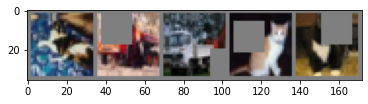

In [0]:
show_images.show_images(trainloader, classes)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
        self.prepLayer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(),  
            )
        #Define Convolutions to calculate Layer1
        #X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
        self.x1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),       
            )
        #R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 
        self.R1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        #Define Convolutions for Layer2
        # Conv 3x3 [256k] -MaxPooling2D-BN-ReLU
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(),   
            )
        #Define Convolutions to calculate Layer3
        # Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
        self.x2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(),   
            )
        #R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
        self.R2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(),  
            )
        #MaxPooling with Kernel Size 4
        self.pool = nn.MaxPool2d(4, 4)
        #FC Layer 
        self.fc = nn.Linear(in_features = 512, out_features = 10, bias=False)

    def forward(self, x):
        #prepLayer 
        prepLayer = self.prepLayer(x) 
        #Add(X, R1)
        x1 = self.x1(prepLayer)
        R1 = self.R1(x1)
        layer1 = x1 + R1

        layer2 = self.layer2(layer1)
        x2 = self.x2(layer2)
        R2 = self.R2(x2)

        #Add(X2, R2)        
        layer3 = R2 + x2
        
        maxpool = self.pool(layer3)
        x = maxpool.view(maxpool.size(0),-1)

        fc = self.fc(x)
        return F.log_softmax(fc.view(-1,10), dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9 ,weight_decay = 0.005)
scheduler = OneCycleLR(optimizer, max_lr = 0.01, total_steps=None, epochs=24, steps_per_epoch=1, pct_start=0.2083, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

In [0]:
test_loss = []
test_acc = []
train_loss = []
train_acc = []
EPOCHS = 24
best_acc = 0
for epoch in range(EPOCHS):
     print("\n EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/school_of_ai/chap11/bestmodel.pt")

  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 1 LR: 0.0010152749669542311


Loss=0.9809871912002563 Batch_id=390 Accuracy=69.20: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7232/10000 (72.32%)

accuracy increased, Saving model....

 EPOCH: 2 LR: 0.001014256237652641


Loss=0.6176938414573669 Batch_id=390 Accuracy=73.20: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7706/10000 (77.06%)

accuracy increased, Saving model....

 EPOCH: 3 LR: 0.0010116261003133202


Loss=0.5070735216140747 Batch_id=390 Accuracy=75.94: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7865/10000 (78.65%)

accuracy increased, Saving model....

 EPOCH: 4 LR: 0.0010110263711407522


Loss=0.8116002082824707 Batch_id=390 Accuracy=77.82: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7910/10000 (79.10%)

accuracy increased, Saving model....

 EPOCH: 5 LR: 0.001010664674658183


Loss=0.4443471431732178 Batch_id=390 Accuracy=79.79: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8133/10000 (81.33%)

accuracy increased, Saving model....

 EPOCH: 6 LR: 0.0010096623628540178


Loss=0.4524232745170593 Batch_id=390 Accuracy=80.93: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8277/10000 (82.77%)

accuracy increased, Saving model....

 EPOCH: 7 LR: 0.0010090135068690975


Loss=0.48064690828323364 Batch_id=390 Accuracy=82.25: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8187/10000 (81.87%)


 EPOCH: 8 LR: 0.0010096040278998082


Loss=0.5411456823348999 Batch_id=390 Accuracy=83.21: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8352/10000 (83.52%)

accuracy increased, Saving model....

 EPOCH: 9 LR: 0.0010086772711241476


Loss=0.40145283937454224 Batch_id=390 Accuracy=84.36: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8448/10000 (84.48%)

accuracy increased, Saving model....

 EPOCH: 10 LR: 0.001008245030015999


Loss=0.36286404728889465 Batch_id=390 Accuracy=85.10: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8535/10000 (85.35%)

accuracy increased, Saving model....

 EPOCH: 11 LR: 0.0010079047584626395


Loss=0.30884939432144165 Batch_id=390 Accuracy=85.82: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8535/10000 (85.35%)


 EPOCH: 12 LR: 0.0010076583489264446


Loss=0.38637760281562805 Batch_id=390 Accuracy=86.56: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8455/10000 (84.55%)


 EPOCH: 13 LR: 0.0010080813048442834


Loss=0.3280062675476074 Batch_id=390 Accuracy=87.34: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8720/10000 (87.20%)

accuracy increased, Saving model....

 EPOCH: 14 LR: 0.0010067161198248622


Loss=0.3524599075317383 Batch_id=390 Accuracy=87.98: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8655/10000 (86.55%)


 EPOCH: 15 LR: 0.0010071150893146133


Loss=0.30800023674964905 Batch_id=390 Accuracy=88.21: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8619/10000 (86.19%)


 EPOCH: 16 LR: 0.0010072119559296807


Loss=0.3640619218349457 Batch_id=390 Accuracy=88.79: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8701/10000 (87.01%)


 EPOCH: 17 LR: 0.001006886721084725


Loss=0.3018527626991272 Batch_id=390 Accuracy=89.12: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8676/10000 (86.76%)


 EPOCH: 18 LR: 0.0010072068083479145


Loss=0.27980512380599976 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8769/10000 (87.69%)

accuracy increased, Saving model....

 EPOCH: 19 LR: 0.0010064271946433373


Loss=0.3733645975589752 Batch_id=390 Accuracy=90.15: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8706/10000 (87.06%)


 EPOCH: 20 LR: 0.0010071461256761138


Loss=0.2450607270002365 Batch_id=390 Accuracy=90.44: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8838/10000 (88.38%)

accuracy increased, Saving model....

 EPOCH: 21 LR: 0.0010060898733790498


Loss=0.3214362859725952 Batch_id=390 Accuracy=90.98: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8818/10000 (88.18%)


 EPOCH: 22 LR: 0.0010063025637779995


Loss=0.18466071784496307 Batch_id=390 Accuracy=91.27: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8781/10000 (87.81%)


 EPOCH: 23 LR: 0.0010066516181104932


Loss=0.3139473795890808 Batch_id=390 Accuracy=91.60: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8860/10000 (88.60%)

accuracy increased, Saving model....

 EPOCH: 24 LR: 0.001006430069483544


Loss=0.26795822381973267 Batch_id=390 Accuracy=91.75: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]



Test set: Average loss: 0.0026, Accuracy: 8855/10000 (88.55%)



In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/school_of_ai/chap11/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [0]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 88 %


In [0]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 89 %
Accuracy of   car : 92 %
Accuracy of  bird : 81 %
Accuracy of   cat : 73 %
Accuracy of  deer : 90 %
Accuracy of   dog : 76 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 97 %
Accuracy of truck : 92 %


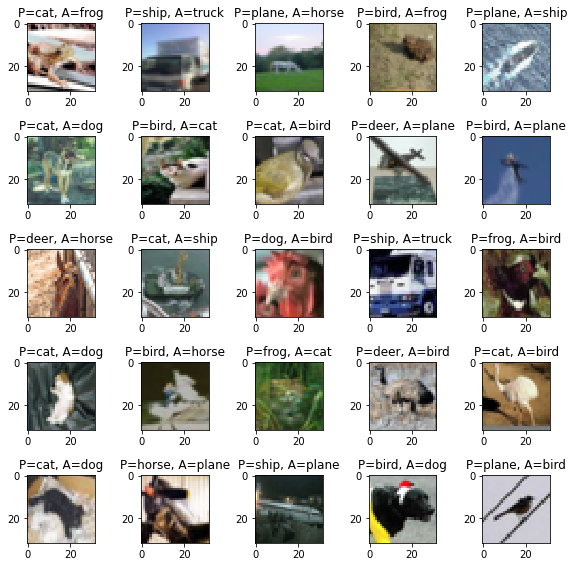

In [0]:
misclassified_images = evaluate.show_misclassified_images(model, device, testloader, classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


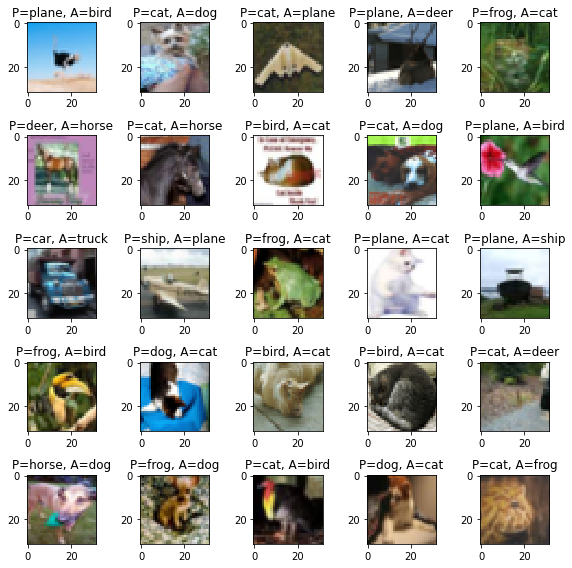

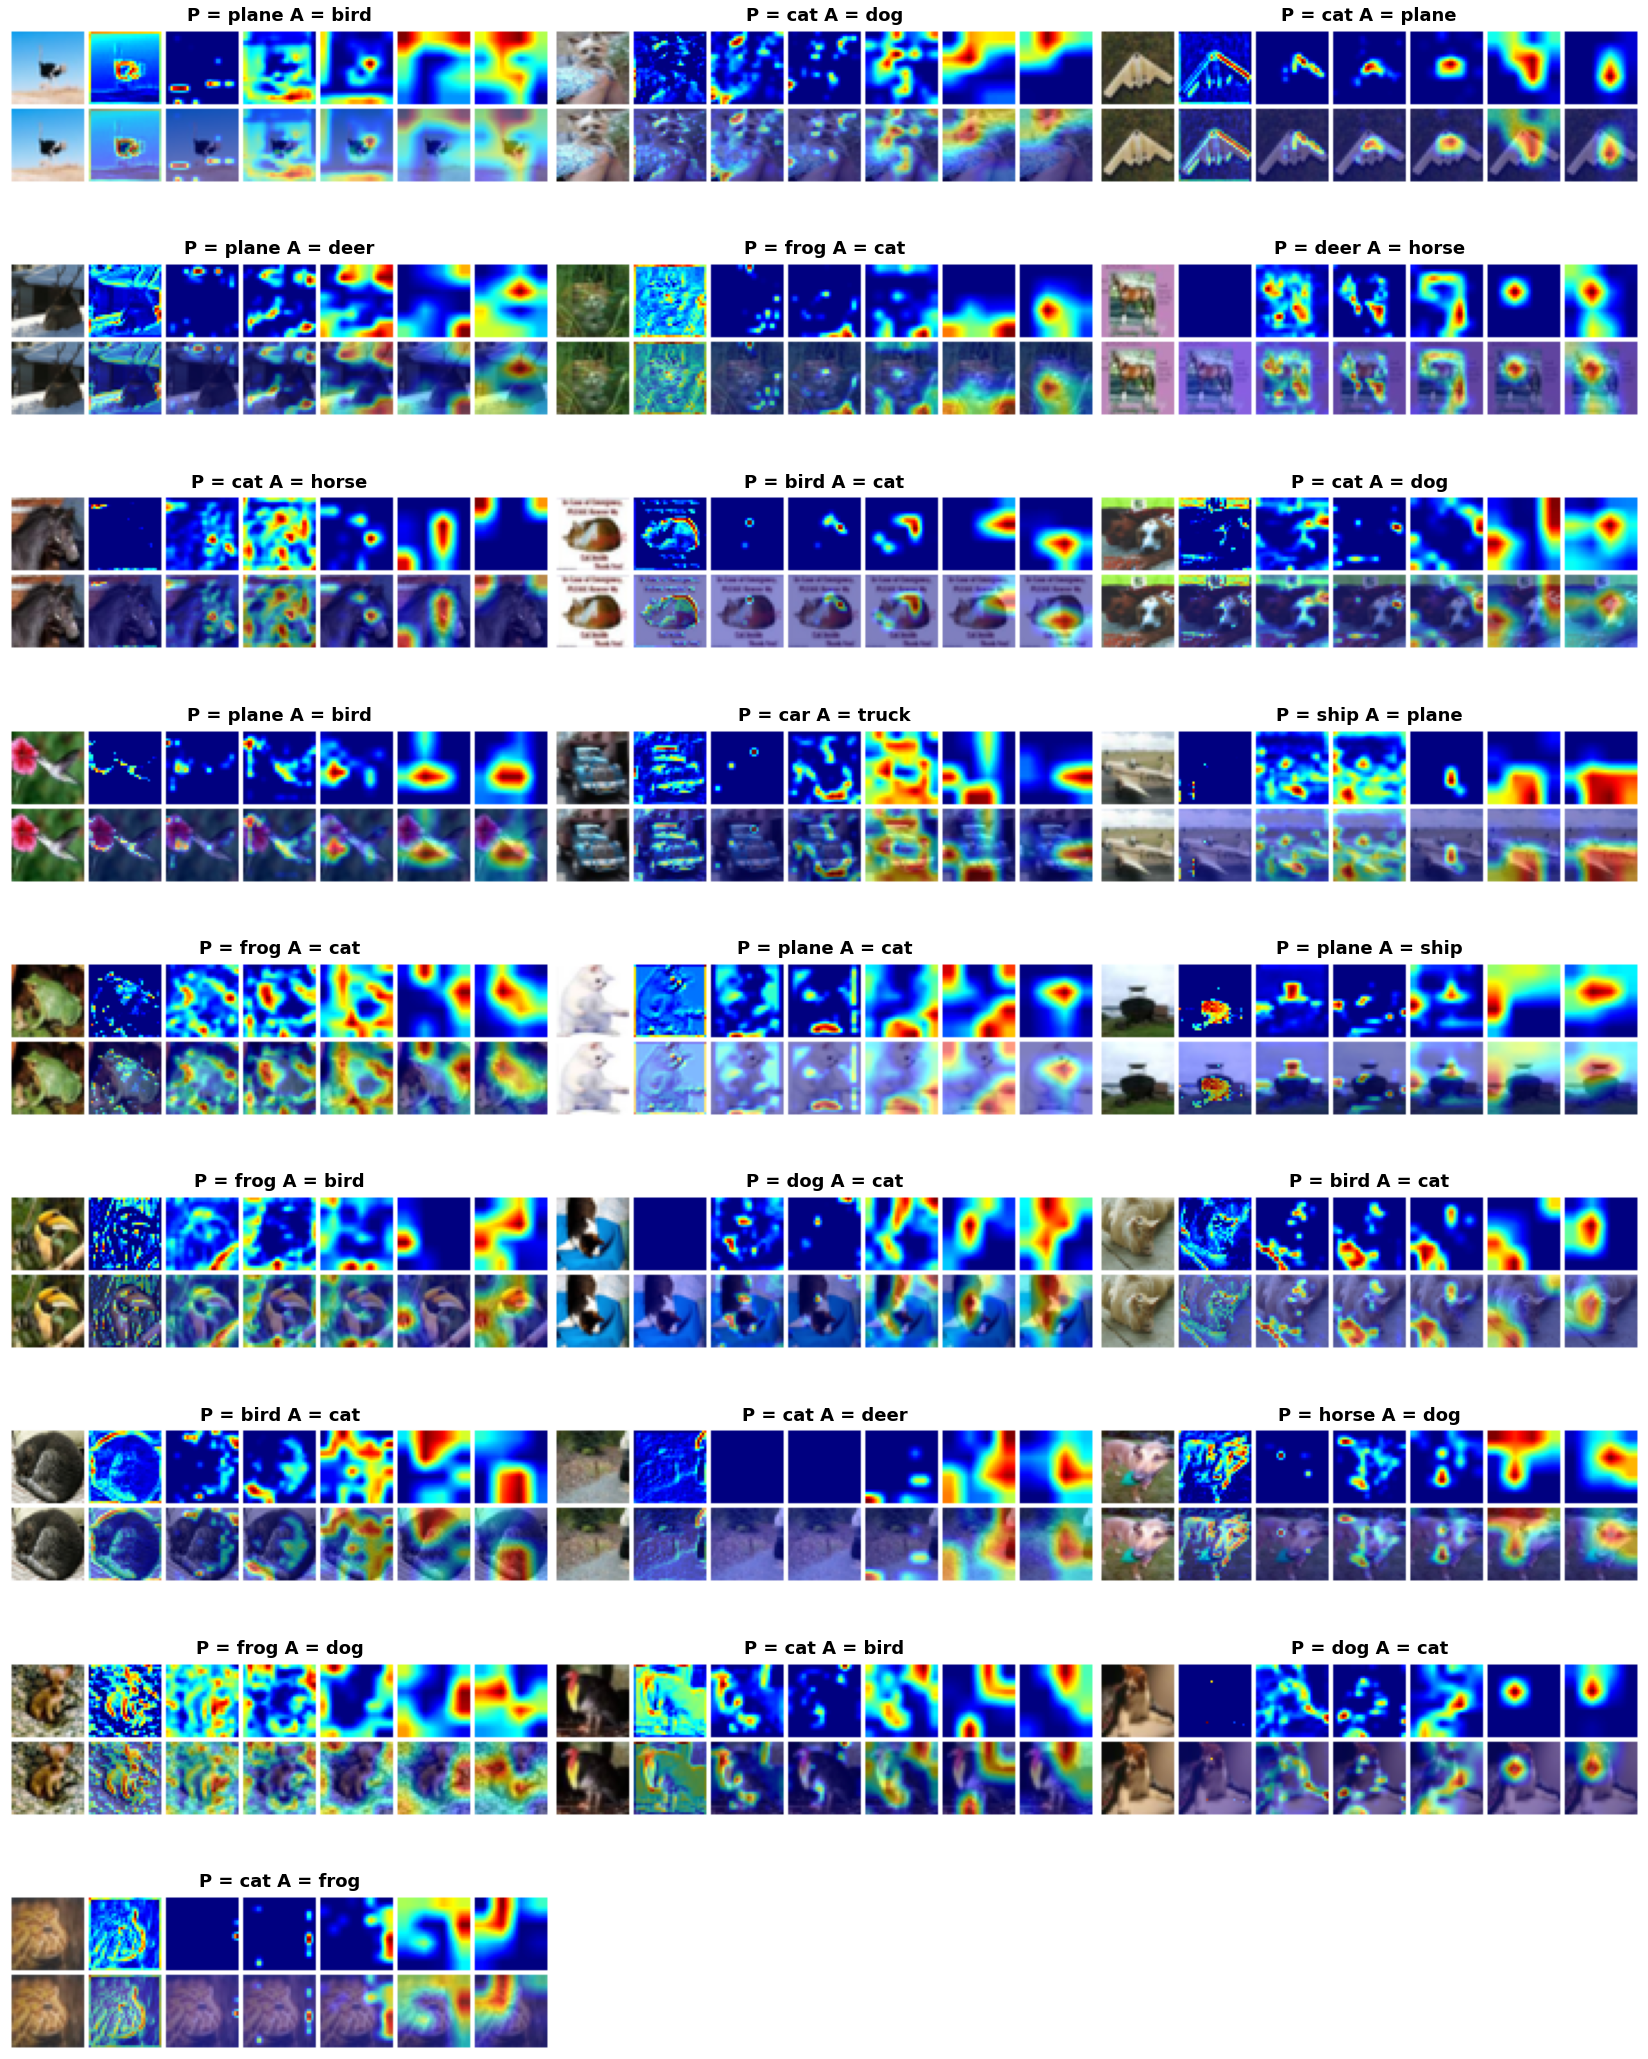

In [0]:
layers = [model.prepLayer, model.x1,model.R1,model.layer2,model.x2,model.R2]
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)
gradcam.GradCamView(miscalssified_images,model,classes,layers)